In [1]:
from pyomo.environ import *

In [2]:
m = AbstractModel()
m.N_value = Param(domain=PositiveIntegers)
m.W_max = Param(domain=PositiveReals)
m.H_max = Param(domain=PositiveReals)
m.N = RangeSet(m.N_value)
m.N_N = Set(initialize=m.N*m.N, filter=lambda _,i,j: i<j)

m.H = Param(m.N, domain=PositiveReals)
m.W = Param(m.N, domain=PositiveReals)

m.x = Var(m.N, domain=NonNegativeReals, bounds=(0,m.W_max))
m.y = Var(m.N, domain=NonNegativeReals, bounds=(0,m.H_max))
m.width = Var(domain=PositiveReals)
m.height = Var(domain=PositiveReals)
m.obj = Var(domain=PositiveReals)
m.obj_func = Objective(expr=m.obj)

# define L-inf norm
m.obj_constr_width = Constraint(expr=m.obj >= m.width)
m.obj_constr_height = Constraint(expr=m.obj >= m.height)
# defines L1 norm
#m.obj_constr_both = Constraint(expr=m.obj >= m.width+m.height)

@m.Constraint(m.N)
def height_constr(m,i):
    return m.y[i]+m.H[i] <= m.height

@m.Constraint(m.N)
def width_constr(m,i):
    return m.x[i]+m.W[i] <= m.width

@m.Disjunction(m.N_N)
def direction_disjunct(m,i,j):
    return [
        m.x[i]+m.W[i] <= m.x[j],
        m.x[j]+m.W[j] <= m.x[i],
        m.y[i]+m.H[i] <= m.y[j],
        m.y[j]+m.H[j] <= m.y[i]
    ]

In [3]:
instance = m.create_instance('rand_params_2D.dat')
opt = SolverFactory('gdpopt')
res = opt.solve(instance)

In [14]:
res

{'Problem': [{'Name': 'unknown', 'Lower bound': 3.09180420145, 'Upper bound': 3.091804134407387, 'Number of objectives': 1, 'Number of constraints': 203, 'Number of variables': 203, 'Number of binary variables': 180, 'Number of integer variables': 0, 'Number of continuous variables': 23, 'Number of nonzeros': None, 'Sense': 1, 'Number of disjunctions': 45}], 'Solver': [{'Name': 'GDPopt (19, 3, 11) - LOA', 'Status': 'ok', 'Message': None, 'User time': 2.171035360021051, 'System time': None, 'Wallclock time': 2.171035360021051, 'Termination condition': 'optimal', 'Termination message': None, 'Timing': Container(OA cut generation = 0.0006852640071883798, initialization = 0.1151139999856241, integer cut generation = 0.0023923380067571998, main loop = 1.9533776140306145, mip = 1.7057214910164475, nlp = 0.24433006800245494, total = 2.171035360021051), 'Iterations': 1}]}

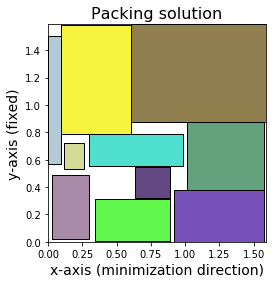

In [5]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import random

fig, ax = plt.subplots(1)
W_max = max([instance.x[i].value+instance.W[i] for i in instance.N])
H_max = max([instance.y[i].value+instance.H[i] for i in instance.N])
plt.xlim((0,W_max))
plt.ylim((0,H_max))
ax.set_aspect('equal')
plt.title('Packing solution', fontsize=16)
plt.xlabel('x-axis (minimization direction)', fontsize=14)
plt.ylabel('y-axis (fixed)', fontsize=14)

for i in instance.N:
    r_border = Rectangle(
        (instance.x[i].value,instance.y[i].value),
        instance.W[i],instance.H[i],
        color='black',fill=False)
    random.seed(i)
    random_color = [random.random() for i in range(3)]
    r_fill = Rectangle(
        (instance.x[i].value,instance.y[i].value),
        instance.W[i],instance.H[i],
        color=random_color, alpha=0.8)
    ax.add_patch(r_fill)
    ax.add_patch(r_border)

In [16]:
minlp_problem = TransformationFactory('gdp.bigm').create_using(instance)
SolverFactory('gurobi').solve(minlp_problem)

{'Problem': [{'Name': 'x396', 'Lower bound': 3.72061643256, 'Upper bound': 3.72091449316, 'Number of objectives': 1, 'Number of constraints': 487, 'Number of variables': 396, 'Number of binary variables': 364, 'Number of integer variables': 364, 'Number of continuous variables': 32, 'Number of nonzeros': 1520, 'Sense': 'minimize'}], 'Solver': [{'Status': 'ok', 'Return code': '0', 'Message': 'Model was solved to optimality (subject to tolerances), and an optimal solution is available.', 'Termination condition': 'optimal', 'Termination message': 'Model was solved to optimality (subject to tolerances), and an optimal solution is available.', 'Wall time': '1035.46600294', 'Error rc': 0, 'Time': 1035.5397326946259}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}